# Common grid daily temperature range QC

This should be a pretty quick QC notebook - literally just check a random time slice in all generated DTR files to ensure it is equal to source tasmax - tasmin:

In [1]:
# parameters cell
working_dir = "/import/beegfs/CMIP6/kmredilla"
input_dir = "/import/beegfs/CMIP6/arctic-cmip6/regrid"

In [2]:
from itertools import product
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from dask.distributed import LocalCluster
from config import (
    output_dir_name,
    dtr_tmp_fn,
    tasmax_tmp_fn,
    tasmin_tmp_fn,
    expected_value_ranges,
)
from slurm_dtr import get_output_dir, get_dtr_dir


working_dir = Path(working_dir)
input_dir = Path(input_dir)

output_dir = get_output_dir(working_dir, output_dir_name)

Define some tests for checking each model / scenario before plotting:

In [ ]:
def test_file_structure(dtr_dir):
    """Test that the files open and look as expected"""

    dtr_fps = list(dtr_dir.glob("dtr*.nc"))
    assert len(dtr_fps) > 0

    for fp in dtr_fps:
        with xr.open_dataset(fp) as ds:
            assert "dtr" in ds.data_vars
            assert list(ds.dims) == ["time", "lat", "lon"]

    return dtr_fps


def test_file_existence(tasmax_dir, tasmin_dir, dtr_dir):
    """Test that the expected files are present for a given model and scenario"""

    # we aren't testing the three-way correspondence between directories but this is tested in the worker script
    tasmax_fps = list(tasmax_dir.glob("tasmax*.nc"))
    assert len(tasmax_fps) > 0
    for tasmax_fp in tasmax_fps:
        tasmax_fn = tasmax_fp.name
        tasmin_fp = tasmin_dir.joinpath(tasmax_fn.replace("tasmax", "tasmin"))
        assert tasmin_fp.exists()
        # this should give us the DTR analog file name
        dtr_fp = dtr_dir.joinpath(tasmax_fp.name.replace("tasmax", "dtr"))
        assert dtr_fp.exists()

    n_tasmax_fps = len(tasmax_fps)
    n_tasmin_fps = len(list(tasmin_dir.glob("tasmin*.nc")))
    n_dtr_fps = len(list(dtr_dir.glob("dtr*.nc")))
    assert n_tasmin_fps == n_tasmax_fps == n_dtr_fps


def test_value_range(dtr_fps):
    """Ensure all data values fall within expected range"""

    # start up a dask client for the final range check
    with LocalCluster(
        n_workers=int(0.9 * cpu_count()),
        memory_limit="4GB",
    ) as cluster:
        with xr.open_mfdataset(dtr_fps) as ds:
            assert ds["dtr"].max() < expected_value_ranges["dtr"]["maximum"]
            assert ds["dtr"].min() >= expected_value_ranges["dtr"]["minimum"]
            # checks that files aren't all the same value
            assert ~np.all(ds["dtr"].values[0, 0, 0] == ds["dtr"].values)

Define a function for plotting a random slice of a DTR file and re-computed DTR from the source files:

In [44]:
def plot_check(model, scenario, year):
    dtr_dir = get_dtr_dir(output_dir, model, scenario)

    dtr_fps = test_file_structure(dtr_dir)
    test_value_range(dtr_fps)
    test_file_existence(tasmax_dir, tasmin_dir, dtr_dir)

    tasmax_dir = input_dir.joinpath(f"{model}/{scenario}/day/tasmax/")
    tasmin_dir = input_dir.joinpath(f"{model}/{scenario}/day/tasmin/")

    dtr_fp = dtr_dir.joinpath(
        dtr_tmp_fn.format(model=model, scenario=scenario, year=year)
    )
    tasmax_fp = tasmax_dir.joinpath(
        tasmax_tmp_fn.format(model=model, scenario=scenario, year=year)
    )
    tasmin_fp = tasmin_dir.joinpath(
        tasmin_tmp_fn.format(model=model, scenario=scenario, year=year)
    )

    try:
        dtr_ds = xr.open_dataset(dtr_fp)
    except FileNotFoundError:
        print(f"{dtr_fp} not found")

        return

    tasmax_ds = xr.open_dataset(tasmax_fp)
    tasmin_ds = xr.open_dataset(tasmin_fp)

    rdate = np.random.choice(dtr_ds.time.values)
    dtr_da = dtr_ds["dtr"].sel(time=rdate)
    recomp_da = tasmax_ds["tasmax"].sel(time=rdate) - tasmin_ds["tasmin"].sel(
        time=rdate
    )
    # extra check that values are numerically identical
    try:
        assert np.array_equal(recomp_da.data, dtr_da.data, equal_nan=True)
    except AssertionError:
        try:
            recomp_da = recomp_da.where(recomp_da >= 0, 0.0000999)
            assert np.array_equal(recomp_da.data, dtr_da.data, equal_nan=True)
            print(
                f"Match achieved after bounding negative DTR values at 0 ({model},{scenario})"
            )
        except AssertionError:
            print(
                f"Re-computed DTR did not match production dataset for {model}, {scenario}"
            )

    # plot map and histogram
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    dtr_da.plot(ax=axes[0])
    dtr_da.plot.hist(ax=axes[1])

    fig.suptitle(f"DTR for model={model}, scenario={scenario}")
    plt.show()

    return

Set up model / scenario groups to iterate over. Projected data first:

In [4]:
# all year / model / scenario combos
years = np.arange(2015, 2101)
prod_models = [
    "CNRM-CM6-1-HR",
    "EC-Earth3-Veg",
    "GFDL-ESM4",
    "HadGEM3-GC31-LL",
    "HadGEM3-GC31-MM",
    "KACE-1-0-G",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MRI-ESM2-0",
    "NorESM2-MM",
    "TaiESM1",
    "CESM2-WACCM",
]

# full list of scenarios for production dataset
prod_scenarios = [
    "historical",
    "ssp126",
    "ssp245",
    "ssp370",
    "ssp585",
]

groups = list(product(prod_models, prod_scenarios))

Iterate and plot:

/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/CNRM-CM6-1-HR/ssp126/dtr/dtr_day_CNRM-CM6-1-HR_ssp126_regrid_20920101-20921231.nc not found
/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/CNRM-CM6-1-HR/ssp245/dtr/dtr_day_CNRM-CM6-1-HR_ssp245_regrid_20350101-20351231.nc not found
/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/CNRM-CM6-1-HR/ssp370/dtr/dtr_day_CNRM-CM6-1-HR_ssp370_regrid_20270101-20271231.nc not found
/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/CNRM-CM6-1-HR/ssp585/dtr/dtr_day_CNRM-CM6-1-HR_ssp585_regrid_20740101-20741231.nc not found
/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/EC-Earth3-Veg/ssp126/dtr/dtr_day_EC-Earth3-Veg_ssp126_regrid_20510101-20511231.nc not found
/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/EC-Earth3-Veg/ssp245/dtr/dtr_day_EC-Earth3-Veg_ssp245_regrid_20300101-20301231.nc not found
/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/EC-Earth3-Veg/ssp370/dtr/dtr_day_EC-Earth3-Veg_ssp370_regrid_20830101-2083123

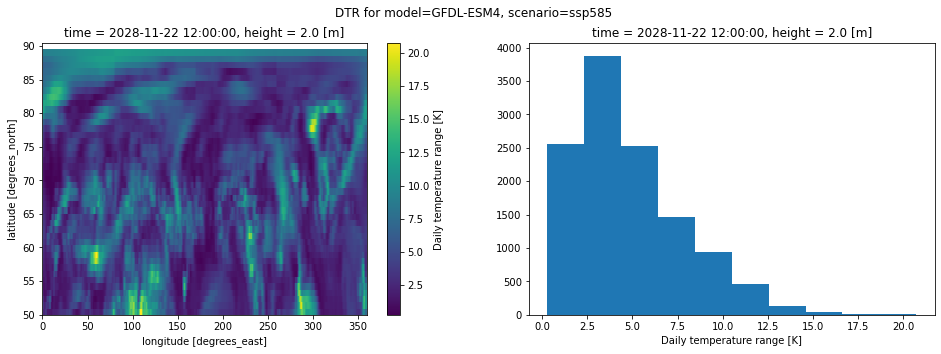

/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/HadGEM3-GC31-LL/ssp126/dtr/dtr_day_HadGEM3-GC31-LL_ssp126_regrid_20240101-20241231.nc not found
/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/HadGEM3-GC31-LL/ssp245/dtr/dtr_day_HadGEM3-GC31-LL_ssp245_regrid_20310101-20311231.nc not found
/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/HadGEM3-GC31-LL/ssp370/dtr/dtr_day_HadGEM3-GC31-LL_ssp370_regrid_20380101-20381231.nc not found
/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/HadGEM3-GC31-LL/ssp585/dtr/dtr_day_HadGEM3-GC31-LL_ssp585_regrid_20610101-20611231.nc not found
/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/HadGEM3-GC31-MM/ssp126/dtr/dtr_day_HadGEM3-GC31-MM_ssp126_regrid_20670101-20671231.nc not found
/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/HadGEM3-GC31-MM/ssp245/dtr/dtr_day_HadGEM3-GC31-MM_ssp245_regrid_20400101-20401231.nc not found
/import/beegfs/CMIP6/kmredilla/dtr_processing/netcdf/HadGEM3-GC31-MM/ssp370/dtr/dtr_day_HadGEM3-GC31-MM_ss

In [46]:
for model, scenario in groups:
    year = np.random.choice(years)
    plot_check(model, scenario, year)